In [8]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [9]:
# ==============================
# EXERCISE 8A - SENTIMENT ANALYSIS CLASSIFIER
# Using RNN and LSTM Models on Tweets_Data.csv
# ==============================

# Step 1: Importing Libraries and Resources
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [11]:
nltk.download('stopwords')
nltk.download('wordnet')
df = pd.read_csv("D:\Downloads\Tweets_Data.csv")
print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (27481, 4)
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative  


[nltk_data] Downloading package stopwords to C:\Users\Monisha
[nltk_data]     Sarai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Monisha
[nltk_data]     Sarai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
text_col = 'text' if 'text' in df.columns else df.columns[0]
label_col = 'sentiment' if 'sentiment' in df.columns else df.columns[1]

df = df[[text_col, label_col]].dropna()
df.rename(columns={text_col: 'review', label_col: 'sentiment'}, inplace=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


In [13]:
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower().split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    return ' '.join(text)

df['cleaned_review'] = df['review'].apply(clean_text)

# Step 3: Target Label Encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

# Step 4: Text Tokenization and Padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_review'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])
max_len = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_len)
y = pd.get_dummies(df['label']).values  # one-hot encoding

# Step 5: Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Define model parameters
vocab_size = 5000
embedding_dim = 100
hidden_dim = 64
dropout_rate = 0.5
epochs = 5
batch_size = 64


Classes: ['negative' 'neutral' 'positive']


In [14]:

# Step 7: Build and Train RNN Model
rnn_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    SimpleRNN(hidden_dim, return_sequences=False),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax')
])

rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("\nTraining SimpleRNN model...")
rnn_history = rnn_model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size,
    validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=2)]
)

# Step 8: Build and Train LSTM Model
lstm_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    LSTM(hidden_dim, return_sequences=False),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax')
])

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("\nTraining LSTM model...")
lstm_history = lstm_model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size,
    validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=2)]
)

# Step 9: Evaluate and Compare Models
rnn_pred = np.argmax(rnn_model.predict(X_val), axis=1)
lstm_pred = np.argmax(lstm_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)


C:\Users\Monisha Sarai\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training SimpleRNN model...
Epoch 1/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5634 - loss: 0.9099 - val_accuracy: 0.6758 - val_loss: 0.7613
Epoch 2/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7451 - loss: 0.6469 - val_accuracy: 0.6809 - val_loss: 0.7843
Epoch 3/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8261 - loss: 0.4691 - val_accuracy: 0.6472 - val_loss: 0.8948

Training LSTM model...
Epoch 1/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.6085 - loss: 0.8590 - val_accuracy: 0.6936 - val_loss: 0.7334
Epoch 2/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7376 - loss: 0.6493 - val_accuracy: 0.7000 - val_loss: 0.7269
Epoch 3/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.7746 - loss: 0.5764 - val_accuracy: 0.6958 - val_loss: 0.7370
Epoch 4/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7971 - loss: 0.5263 - val_accuracy: 0.6909 - val_loss: 0.7627
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
172/17


RNN Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.62      0.61      1572
           1       0.61      0.63      0.62      2236
           2       0.73      0.69      0.71      1688

    accuracy                           0.65      5496
   macro avg       0.65      0.65      0.65      5496
weighted avg       0.65      0.65      0.65      5496


LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.62      0.66      1572
           1       0.66      0.68      0.67      2236
           2       0.72      0.77      0.75      1688

    accuracy                           0.69      5496
   macro avg       0.69      0.69      0.69      5496
weighted avg       0.69      0.69      0.69      5496



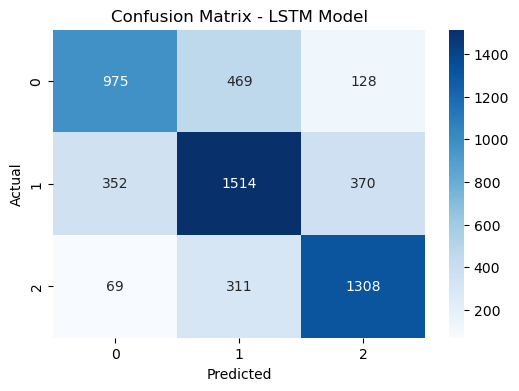

✅ LSTM Model saved as sentiment_lstm.h5


In [15]:

print("\nRNN Classification Report:")
print(classification_report(y_true, rnn_pred))

print("\nLSTM Classification Report:")
print(classification_report(y_true, lstm_pred))

# Confusion Matrix for LSTM
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, lstm_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - LSTM Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 10: Save best model
lstm_model.save("/mnt/data/sentiment_lstm.h5")
print("✅ LSTM Model saved as sentiment_lstm.h5")


In [21]:
# ==============================
# EXERCISE 8B - SENTIMENT PREDICTION FROM SAVED MODEL
# ==============================

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import numpy as np

nltk.download('stopwords')
nltk.download('wordnet')

# Load the trained model
model_path = "/mnt/data/sentiment_lstm.h5"
model = load_model(model_path)
print("✅ Loaded saved LSTM model.")

# Recreate tokenizer setup
df = pd.read_csv("D:\Downloads\Tweets_Data.csv")
text_col = 'text' if 'text' in df.columns else df.columns[0]
label_col = 'sentiment' if 'sentiment' in df.columns else df.columns[1]
df[text_col] = df[text_col].fillna("").astype(str)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower().split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    return ' '.join(text)

df['cleaned_review'] = df[text_col].apply(clean_text)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_review'])
max_len = max(len(seq) for seq in tokenizer.texts_to_sequences(df['cleaned_review']))

# Step 2: Input new review
print("\nEnter a review or tweet to predict sentiment:")
user_input = input("Review: ")
cleaned_input = clean_text(user_input)
sequence = tokenizer.texts_to_sequences([cleaned_input])
padded = pad_sequences(sequence, maxlen=max_len)

# Step 3: Predict sentiment
pred = model.predict(padded)
sentiment_classes = ['Negative', 'Neutral', 'Positive']  # adjust based on your dataset
predicted_label = sentiment_classes[np.argmax(pred)]
print(f"\n🧾 Review: {user_input}")
print(f"🔮 Predicted Sentiment: {predicted_label}")


[nltk_data] Downloading package stopwords to C:\Users\Monisha
[nltk_data]     Sarai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Monisha
[nltk_data]     Sarai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✅ Loaded saved LSTM model.

Enter a review or tweet to predict sentiment:


Review:  okay


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step

🧾 Review: okay
🔮 Predicted Sentiment: Neutral
